In [1]:
''' install below dependencies if needed 


pip install opencv-python
pip install ultralytics
pip install tensorflow
'''

' install below dependencies if needed \n\n\npip install opencv-python\npip install ultralytics\npip install tensorflow\n'

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
#from scipy.misc import imread

import tensorflow.keras as keras
from tensorflow.keras import Model
from matplotlib.pyplot import imshow
from tensorflow.keras.callbacks import ModelCheckpoint
import cv2

from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.metrics import accuracy_score

2024-04-13 20:27:44.475520: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
data = keras.utils.image_dataset_from_directory(
    directory='../../data/Faces',
    labels='inferred',
    label_mode='categorical',
    batch_size=140,
    image_size=(1000, 1000),
)

Found 140 files belonging to 6 classes.


(1000, 1000, 3)


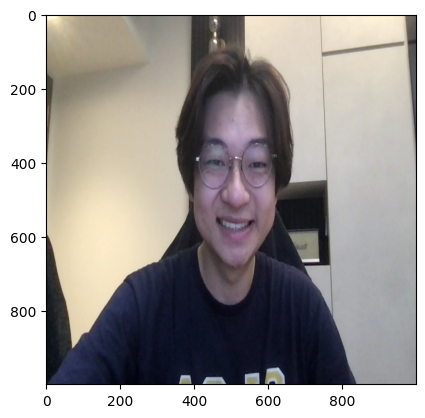

In [4]:
#plot a sample image

for images, label in data.take(1):
    print(np.array(images, dtype='uint8')[10].shape)
    imshow(np.array(images, dtype='uint8')[10])

In [5]:
#Instantiate face detector
#face_classifier = cv2.CascadeClassifier(
#    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
#)

In [6]:
face_classifier = YOLO("../../app/src/face_detection/model/yolov8n-face.pt")


WARNING ⚠️ ../../app/src/face_detection/model/yolov8n-face.pt appears to require 'omegaconf', which is not in ultralytics requirements.
AutoInstall will run now for 'omegaconf' but this feature will be removed in the future.
Recommend fixes are to train a new model using the latest 'ultralytics' package or to run a command with an official YOLOv8 model, i.e. 'yolo predict model=yolov8n.pt'
requirements: Ultralytics requirement ['omegaconf'] not found, attempting AutoUpdate...
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144574 sha256=b47438332e8741788018e265fd04e234e7df00d27bd430866c17212315f26ead
  Stored in directory: /private/var/folders/dr/gs9wbbgs2zlcfyqybn5vvrw40000gn/T/pip-ephem-wheel-cache-s6sc9tvn/wheels/b1/a3/c2/6df046c09459b73cc9bb6c4401b0be6c47048baf9a1617c485
Successfully built antlr4-python3-runtime

requirements: AutoUpdate success ✅ 5.3s, installed 1 package: ['omegaconf']
requirements: ⚠️ Restart runtime or rer

You should consider upgrading via the '/Users/saxyrinchen/.pyenv/versions/3.8.11/bin/python3.8 -m pip install --upgrade pip' command.


In [7]:
#convert to numpy array
numpy_generator = data.as_numpy_iterator()
X, y = numpy_generator.next()


In [8]:
#get the shape of the array
X.shape

(140, 1000, 1000, 3)

In [9]:
y.shape

(140, 6)

In [10]:
num_faces = 0
#create a dataset with cropped faces and its corresponding label
X_cropped = []
y_cropped = []
for i in range(140):
  #  print(i)
    face = np.array(X[i], dtype = 'uint8')
    faces = face_classifier.predict(face)
    boxes = faces[0].boxes.xyxy.tolist()
    if boxes:
        num_faces += 1
        #extract the face based on the output from the YOLOv8 model        
        left, bottom, right, top = boxes[0]
        cropped_face = face[int(bottom):int(top), int(left):int(right)]
        #resize cropped face to a std shape, 100x100 for now but can adjust this
        pil_face = Image.fromarray(np.uint8(cropped_face)).convert('L')
        pil_face = pil_face.resize((48, 48))
        numpy_cropped_face = np.array(pil_face)
        #append this to the new list containing all cropped faces
        X_cropped.append(numpy_cropped_face)
        corresponding_label = y[i]
        #append the labels to the new label list
        y_cropped.append(corresponding_label)
        #uncomment below lines of code to see the cropped face visualisation
        imshow(numpy_cropped_face, cmap = 'gray')
        plt.show()
    



0: 640x640 1 face, 488.1ms
Speed: 60.5ms preprocess, 488.1ms inference, 3096.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 186.8ms
Speed: 5.9ms preprocess, 186.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 190.9ms
Speed: 3.0ms preprocess, 190.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 213.4ms
Speed: 5.0ms preprocess, 213.4ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 196.9ms
Speed: 3.0ms preprocess, 196.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 189.9ms
Speed: 3.0ms preprocess, 189.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 292.9ms
Speed: 4.3ms preprocess, 292.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 229.4ms
Speed: 5.9ms preprocess, 229.4ms inference, 0.9ms postprocess per image at shape (1, 3

In [11]:
#Run modelling in these cells
X_cropped = np.array(X_cropped)
#flatten the image into 1d vector that is suitable into input to classical ML models
X_log_reg_input = X_cropped.reshape(X_cropped.shape[0], X_cropped.shape[1] * X_cropped.shape[2])

In [12]:
y_log_reg = np.argmax(y_cropped, axis = 1)

### Logistic regression.
In this cell, we shall try a simple logistic regression model as a baseline. We expect the model to not perform well because the data we have is far less than the dimension.

In [13]:
#train, test split

X_train, X_test, y_train, y_test = train_test_split(X_log_reg_input, y_log_reg, test_size=0.2)

In [14]:
X_test.shape

(28, 10000)

In [15]:
log_reg = LogisticRegression()

log_reg.fit(X_train, y_train)

/Users/saxyrinchen/.pyenv/versions/3.8.11/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [16]:
#evaluate the algorithm

y_pred = log_reg.predict(X_test)

In [17]:
y_pred

array([5, 5, 0, 0, 1, 0, 3, 0, 5, 5, 5, 3, 3, 1, 2, 0, 0, 3, 5, 1, 4, 3, 4, 0, 1, 3, 5, 2])

In [18]:
#Logistic regression performs much better than a random model but still not as good as expected
accuracy_score(y_test, y_pred)

0.5357142857142857

In [11]:
#testing pretrained

pretrained_model = keras.models.load_model('../../app\src/Mood_detector/trained_emotion.keras')

In [17]:
pretrained_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm1                     │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_11 (Conv2D)                │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm12                    │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_21 (Conv2D)                │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm21                    │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool2 (MaxPooling2D)        │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm3                     │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_31 (Conv2D)                │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm31                    │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool3 (MaxPooling2D)        │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm4                     │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_41 (Conv2D)                │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm41                    │ (None, 6, 6, 512)      │         2,04

 Total params: 21,641,815 (82.56 MB)

 Trainable params: 7,212,743 (27.51 MB)

 Non-trainable params: 3,584 (14.00 KB)

 Optimizer params: 14,425,488 (55.03 MB)

In [19]:
pretrained_input = np.array(X_cropped).reshape((138, 48, 48, 1))

In [30]:
output = pretrained_model.predict(pretrained_input)
output.shape

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


(138, 7)

(138, 6)

In [35]:
class_predictions = np.argmax(output[:, [0, ] + list(range(2,7))], axis = 1)

5

In [27]:
max(class_predictions)

6

In [36]:
accuracy_score(y_true=y_log_reg, y_pred=class_predictions)

0.42028985507246375

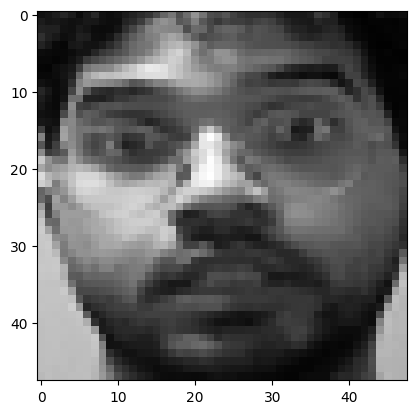

In [26]:
imshow(np.array(pretrained_input[0], dtype='uint8'), cmap='gray')